In [1]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from keras_preprocessing.image import ImageDataGenerator
import os

In [2]:
input_path = '/kaggle/input/appa-real-face-cropped'
pth = os.listdir(input_path)
pth

['final_files', 'labels.csv']

In [3]:
df = pd.read_csv(input_path + '/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
df.value_counts('real_age').to_frame().head(20).T

real_age,30,25,27,26,28,23,24,16,18,19,22,20,32,40,29,17,50,34,1,35
0,317,315,229,226,217,213,211,193,193,180,179,178,174,167,164,163,156,156,149,147


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


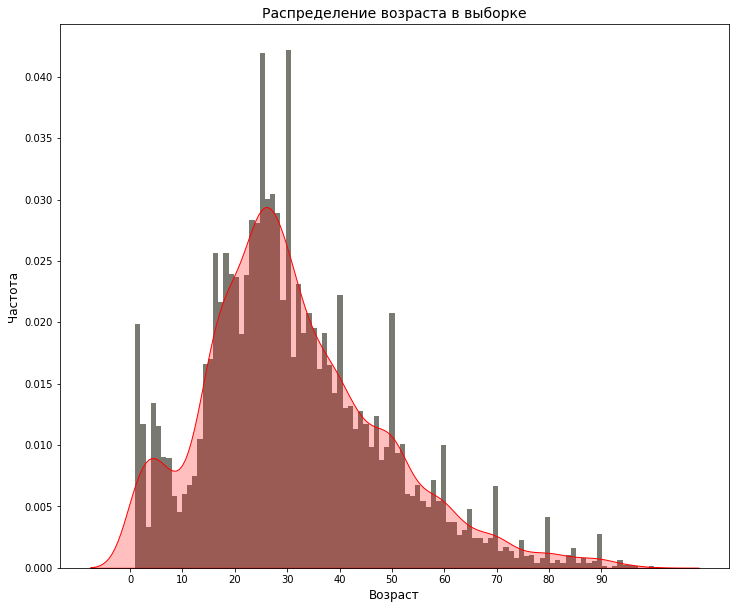

In [6]:
df['real_age'].hist(bins=100, grid=False, figsize=(12,10), density=True)
plt.title('Распределение возраста в выборке', fontsize=14)
sns.distplot(df['real_age'], rug=False, kde_kws={'shade':True, 'color':'r'}, bins=100)
plt.xlabel('Возраст', fontsize=12)
plt.xticks(np.arange(0, 100, step=10)) 
plt.ylabel('Частота', fontsize=12)
plt.show()

In [7]:
directory = input_path + '/final_files/final_files/'
datagen_flow = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df,
                                                        directory,
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        class_mode='raw')

Found 7591 validated image filenames.


In [8]:
features, target = next(datagen_flow)

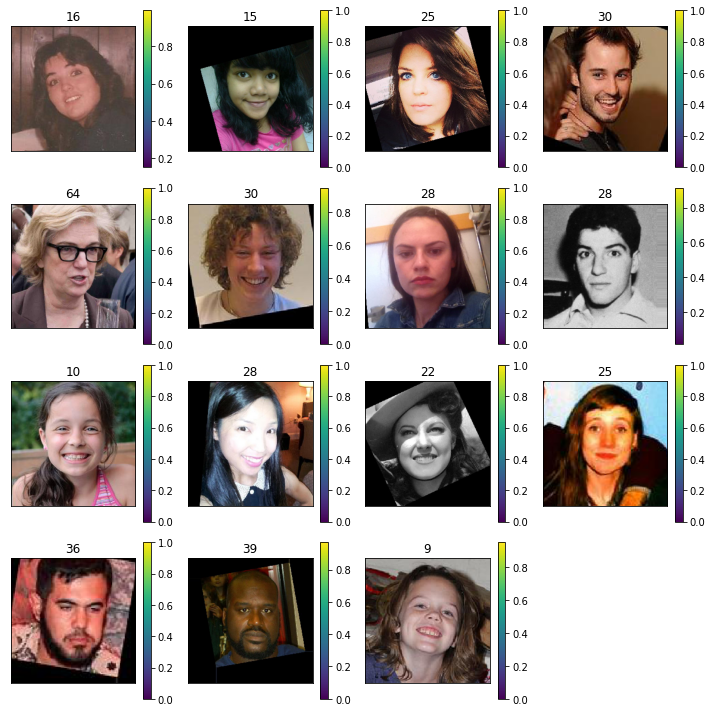

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'{target[i]}')
    plt.imshow(features[i])
    plt.colorbar()
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [10]:
optimizer = Adam(learning_rate=0.0001)


def load_train(input_path):
    df = pd.read_csv(input_path + '/labels.csv')
    directory = input_path + '/final_files/final_files/'
    train_datagen = ImageDataGenerator(vertical_flip=False,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   rescale=1/255.,
                                   validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                        directory=directory,
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        class_mode='raw',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        subset='training',
                                                        seed=12345)
    return train_datagen_flow


def load_test(input_path):
    df = pd.read_csv(input_path + '/labels.csv')
    directory = input_path + '/final_files/final_files/'
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                        directory=directory,
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        class_mode='raw',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        subset='validation',
                                                        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 


    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
  
    # if steps_per_epoch is None:
    #     steps_per_epoch = len(train_data)
    # if validation_steps is None:
    #     validation_steps = len(test_data)

  
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model



In [11]:
train_data = load_train(input_path)
test_data = load_test(input_path)
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


2022-08-23 19:09:23.523639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 19:09:23.627262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 19:09:23.628047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 19:09:23.630488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [12]:
# Обучим модель на 10 эпохах
history = train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None)

2022-08-23 19:09:29.786494: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-23 19:09:36.038352: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


178/178 - 132s - loss: 246.7870 - mae: 11.3085 - val_loss: 556.1568 - val_mae: 18.5424
Epoch 2/10
178/178 - 103s - loss: 96.6811 - mae: 7.3918 - val_loss: 795.2632 - val_mae: 23.2793
Epoch 3/10
178/178 - 105s - loss: 72.1076 - mae: 6.5028 - val_loss: 356.1049 - val_mae: 14.0598
Epoch 4/10
178/178 - 104s - loss: 58.4243 - mae: 5.8188 - val_loss: 123.6300 - val_mae: 8.4448
Epoch 5/10
178/178 - 104s - loss: 50.9991 - mae: 5.4989 - val_loss: 127.1546 - val_mae: 8.5989
Epoch 6/10
178/178 - 104s - loss: 46.1211 - mae: 5.1896 - val_loss: 114.5800 - val_mae: 8.6341
Epoch 7/10
178/178 - 103s - loss: 37.8302 - mae: 4.7247 - val_loss: 136.1860 - val_mae: 8.4117
Epoch 8/10
178/178 - 104s - loss: 34.6258 - mae: 4.4888 - val_loss: 100.0248 - val_mae: 7.5935
Epoch 9/10
178/178 - 104s - loss: 31.6552 - mae: 4.2966 - val_loss: 91.6769 - val_mae: 6.9539
Epoch 10/10
178/178 - 103s - loss: 28.7302 - mae: 4.1015 - val_loss: 64.5258 - val_mae: 5.9381


In [13]:
# Сохраним модель
model.save("rfa_model")

2022-08-23 19:30:39.628464: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
m = keras.models.load_model('rfa_model')

In [15]:
features_test, target_test = next(test_data) 
predicted = m.predict(features_test)

In [16]:
# Посмотрим на реальный и предсказанный возраст 32 людей из батча 
real_age = pd.DataFrame(target_test, columns=['Реальный возраст'])
predicted_age = pd.DataFrame(round(pd.DataFrame(predicted, columns=['Предсказаный возраст'])).astype('int'))

real_age.merge(predicted_age, how='inner', left_index=True, right_index=True)

,Реальный возраст,Предсказаный возраст
0,1,2
1,5,20
2,39,27
3,40,33
4,2,3
5,45,46
6,33,33
7,20,17
8,39,32
9,49,46


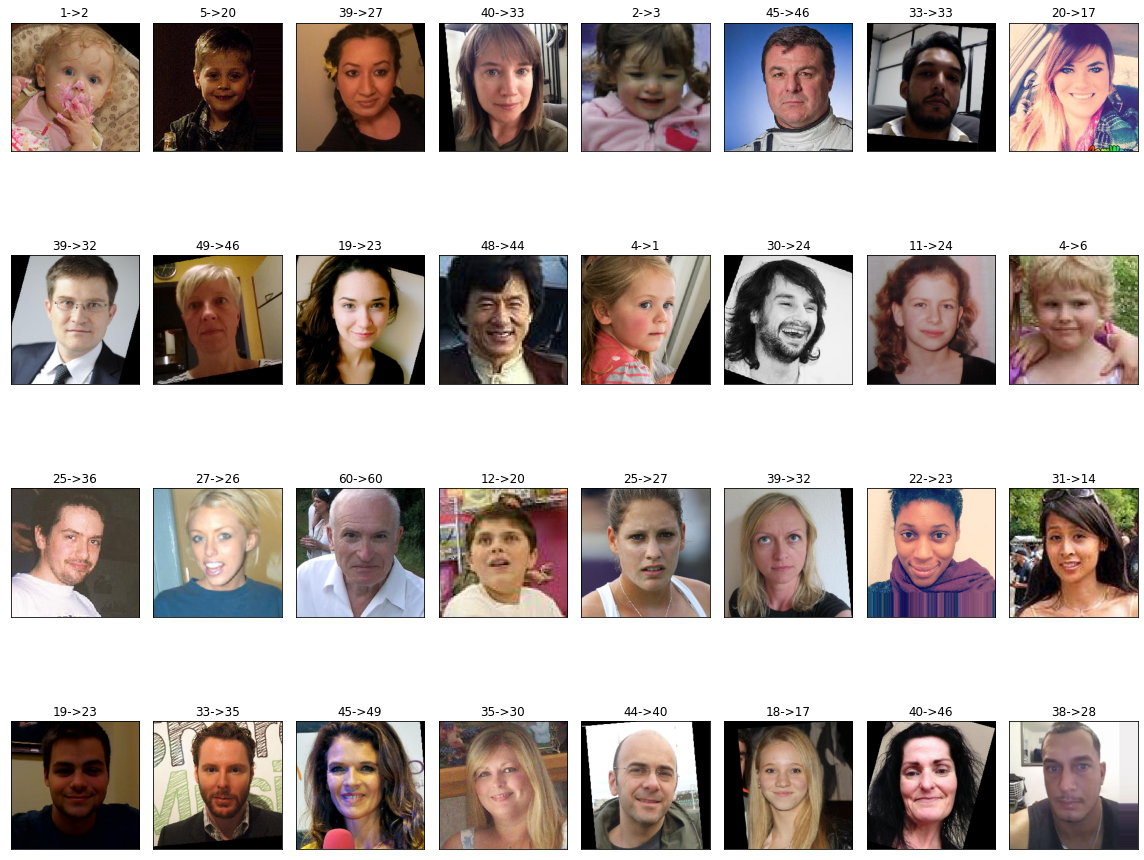

In [17]:
# Посмотрим на предсказанный возраст на фотографиях
fig = plt.figure(figsize=(16,16))
for i in range(len(model.predict(features_test))):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features_test[i])
    plt.title(f'{target_test[i]}->{round(model.predict(features_test)[i][0])}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Анализ модели

* Построена модель регрессии ResNet50 на предобученной выборке `imagenet`. Было увеличено число пикселей входного изображения и число батчей до 32 для повышения точности предсказания модели. За функцию потерь была взята MSE.
* Также применена аугментация, а алгоритм оптимизации функции потерь - Adam c lerning_rаte=0.0001.
* Точность предсказания тестовой выборки составила, оцененая по метрике `MAE` составила 5.9381, что лучше поставленной в задаче метрики 8. 
* Общая ориентация фотографий датасета соблюдена естественным образом, имеются небольние повороты до 20 градусов.
* Присутствуют черно-белые фотографии